In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
from IPython.display import Image, display


In [2]:
def read_voxel_data(file_path):
    with open(file_path, 'r') as f:
        data = [int(num) for line in f for num in line.split()]
    return data

def create_3d_model(data, num_pixels_image, num_images_ct):
    x_dim = num_pixels_image
    y_dim = num_images_ct
    z_dim = num_pixels_image

    expected_size = x_dim * y_dim * z_dim
    actual_size = len(data)

    if actual_size != expected_size:
        raise ValueError(f"Expected {expected_size} integers, but got {actual_size}.")

    model_3d = np.zeros((x_dim, y_dim, z_dim), dtype=int)

    index = 0
    for z in range(z_dim):
        for y in range(y_dim):
            for x in range(x_dim):
                model_3d[x, y, z] = data[index]
                index += 1

    return model_3d

def calculate_voxel_dimensions(pixel_width, slice_width, num_pixels_image):
    voxel_dimensions = [
        (pixel_width * (512 / num_pixels_image)),  # x dimension
        slice_width,                                 # y dimension
        (pixel_width * (512 / num_pixels_image))    # z dimension
    ]
    return voxel_dimensions

# Parameters
file_path = 'f1_12.txt'
num_pixels_image = 128
num_images_ct = 81
pixel_width = 0.6                               # in mm
slice_width = 1                                 # in mm

tissue_color_map = {
    50: (1.0, 1.0, 1.0),   # White for air
    51: (0.7, 0.7, 0.7),   # Light gray for lung (density 0.05)
    52: (0.6, 0.6, 0.6),   # Gray for lung (density 0.13)
    53: (0.5, 0.5, 0.5),   # Dark gray for lung (density 0.30)
    54: (0.4, 0.4, 0.4),   # Darker gray for lung (density 0.47)
    55: (0.3, 0.3, 0.3),   # Darker gray for lung (density 0.65)
    56: (0.8, 0.6, 0.4),   # Brown for fat/soft tissue
    57: (0.9, 0.7, 0.5),   # Lighter brown for fat/soft tissue
    58: (1.0, 0.8, 0.6),   # Light tan for fat/soft tissue
    59: (0.0, 0.0, 1.0),   # Blue for water
    60: (1.0, 0.0, 0.0),   # Red for muscle
    61: (0.8, 0.0, 0.0),   # Dark red for muscle
    62: (0.6, 0.0, 0.0),   # Darker red for muscle
    63: (0.9, 0.9, 0.8),   # Off-white for bone (density 1.48)
    64: (0.8, 0.8, 0.7),   # Light gray for bone (density 1.68)
    65: (0.7, 0.7, 0.6),   # Dark gray for bone (density 1.89)
    66: (0.6, 0.6, 0.5),   # Darker gray for bone (density 2.10)
    89: (0.9, 0.9, 0.7),   # Off-white for fetal bone
    92: (0.9, 0.6, 0.6),   # Light pink for fetal tissue
    91: (0.6, 0.9, 0.6),   # Light green for gestational sac
    90: (0.9, 0.7, 0.9),   # Light lavender for uterus

}

voxel_data = read_voxel_data(file_path)
model_3d = create_3d_model(voxel_data, num_pixels_image, num_images_ct)
voxel_dimensions = calculate_voxel_dimensions(pixel_width, slice_width, num_pixels_image)
print("Voxel Dimensions (mm):", voxel_dimensions)

base_filename = os.path.splitext(file_path)[0]

Voxel Dimensions (mm): [2.4, 1, 2.4]


GIF saved as f1_12_axial.gif


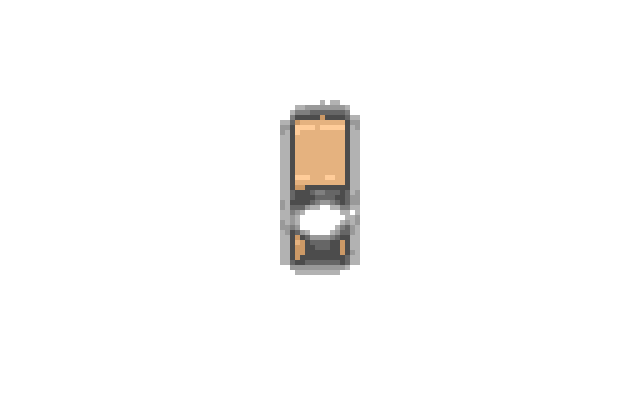

In [3]:
# Axial

def visualize_slice(model_3d, tissue_color_map, slice_index, scale_factor=2):
    slice_data = model_3d[:, :, slice_index]  # Get the z-th slice
    colored_slice = np.zeros((model_3d.shape[0], model_3d.shape[1], 3), dtype=np.uint8)

    for tissue_type, color in tissue_color_map.items():
        colored_slice[slice_data == tissue_type] = np.array(color) * 255

    colored_slice = np.rot90(colored_slice, k=1)
    colored_slice = np.fliplr(colored_slice)

    if scale_factor > 1:
        colored_slice = np.kron(colored_slice, np.ones((scale_factor, scale_factor, 1), dtype=np.uint8))

    return colored_slice

def create_gif_from_slices(model_3d, tissue_color_map, scale_factor, gif_filename='output.gif', duration=0.1):
    z_dim = model_3d.shape[2]
    images = []

    for slice_index in range(z_dim):
        frame = visualize_slice(model_3d, tissue_color_map, slice_index, scale_factor)
        images.append(frame)

    imageio.mimsave(gif_filename, images, duration=duration)
    print(f"GIF saved as {gif_filename}")

    display(Image(filename=gif_filename))

gif_filename = f"{base_filename}_axial.gif"

create_gif_from_slices(model_3d, tissue_color_map, gif_filename=gif_filename, duration=0.1, scale_factor=5)

GIF saved as f1_12_coronal.gif


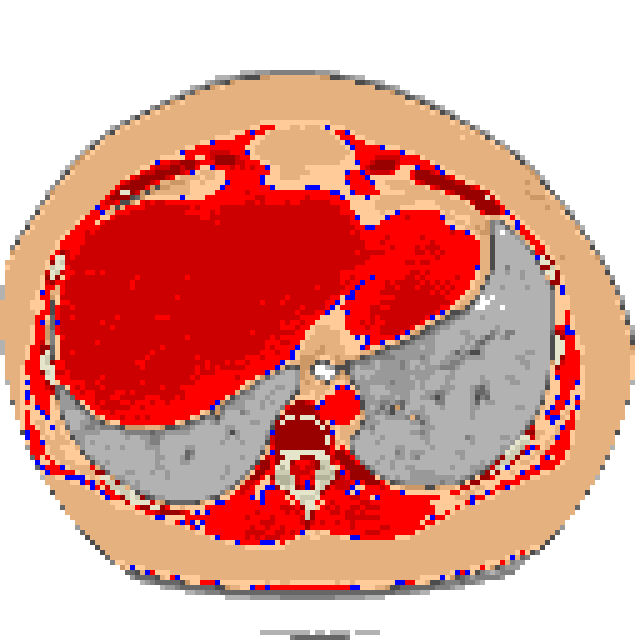

In [4]:
# Coronal

def visualize_slice(model_3d, tissue_color_map, slice_index, scale_factor=2):
    slice_data = model_3d[:, slice_index, :]  # Get the coronal slice (y-axis)
    colored_slice = np.zeros((model_3d.shape[0], model_3d.shape[2], 3), dtype=np.uint8)

    for tissue_type, color in tissue_color_map.items():
        colored_slice[slice_data == tissue_type] = np.array(color) * 255

    colored_slice = np.rot90(colored_slice, k=3)
    colored_slice = np.fliplr(colored_slice)

    if scale_factor > 1:
        colored_slice = np.kron(colored_slice, np.ones((scale_factor, scale_factor, 1), dtype=np.uint8))

    return colored_slice

def create_gif_from_slices(model_3d, tissue_color_map, gif_filename='output.gif', duration=0.1, scale_factor=2):
    y_dim = model_3d.shape[1]
    images = []

    for slice_index in range(y_dim - 1, -1, -1):
        frame = visualize_slice(model_3d, tissue_color_map, slice_index, scale_factor)
        images.append(frame)

    imageio.mimsave(gif_filename, images, duration=duration)
    print(f"GIF saved as {gif_filename}")

    display(Image(filename=gif_filename))

gif_filename = f"{base_filename}_coronal.gif"

create_gif_from_slices(model_3d, tissue_color_map, gif_filename=gif_filename, duration=0.1, scale_factor=5)

GIF saved as f1_12_sagittal.gif


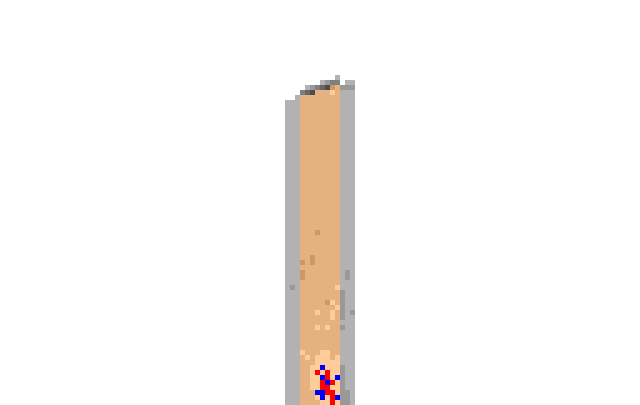

In [5]:
# Sagittal

def visualize_slice(model_3d, tissue_color_map, slice_index, scale_factor=2):
    slice_data = model_3d[slice_index, :, :]  # Get the sagittal slice (x-axis)
    colored_slice = np.zeros((model_3d.shape[1], model_3d.shape[2], 3), dtype=np.uint8)

    for tissue_type, color in tissue_color_map.items():
        colored_slice[slice_data == tissue_type] = (np.array(color) * 255).astype(np.uint8)

    colored_slice = np.rot90(colored_slice, k=2)
    colored_slice = np.fliplr(colored_slice)

    if scale_factor > 1:
        colored_slice = np.kron(colored_slice, np.ones((scale_factor, scale_factor, 1), dtype=np.uint8))

    return colored_slice

def create_gif_from_slices(model_3d, tissue_color_map, gif_filename='output.gif', duration=0.1, scale_factor=2):
    x_dim = model_3d.shape[0]
    images = []

    for slice_index in range(x_dim - 1, -1, -1):
        frame = visualize_slice(model_3d, tissue_color_map, slice_index, scale_factor)
        images.append(frame)

    imageio.mimsave(gif_filename, images, duration=duration)
    print(f"GIF saved as {gif_filename}")

    display(Image(filename=gif_filename))


gif_filename = f"{base_filename}_sagittal.gif"

create_gif_from_slices(model_3d, tissue_color_map, gif_filename=gif_filename, duration=0.1, scale_factor=5)